In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from load_data import *
from util import *
import copy
import gc
import time
import math
np.random.seed(43)

In [2]:
batch_size = 128
epochs = 70
acquired_points = 10
num_classes = 10
acquisition_times = 100
data_variances = [0.05, 0.02, 0.01, 0.1, 0.005]
device = torch.device("mps") if torch.mps.is_available() else "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else device
x_train_new, y_train_new, X_p, y_p, x_val, y_val, x_test, y_test = load_mnist()
x_train_new = x_train_new.to(dtype=torch.float32).to(device)
y_train_new = y_train_new.to(dtype=torch.float32).to(device)
X_p = X_p.to(dtype=torch.float32)
y_p = y_p.to(dtype=torch.float32)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_train shape: torch.Size([60000, 1, 28, 28])
60000 train samples, before reduction
10000 test samples


# VI utils

In [3]:
#This is actually treated as the std
weights_prior_std = 0.01
# This implies that the covariance matrix of each W_i is diag(weights_prior_var^2), ..., weights_prior_var^2)
sigma_1_inv = torch.diag(torch.ones(128) * (1.0 / (weights_prior_std ** 2)))

In [4]:
class HierarchicalRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # /2 width/height,
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(32 * 11 * 11, 128),
            nn.ReLU()
        )

        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax()
        nn.init.normal_(self.fc2.weight, mean=0.0, std=weights_prior_std)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc2(x)
        return x

In [5]:
def compute_pred_cov(sigma_2, model, x, blocks_of_cov_post):
    model.eval()
    y_ast = model(x)
    V_pred = torch.einsum('bd,kde,be->kb', y_ast, blocks_of_cov_post, y_ast).T
    idx = torch.arange(V_pred.shape[0] * sigma_2.shape[0], device=sigma_2.device) % sigma_2.shape[0]
    sigma_2_rep = sigma_2[idx]
    return V_pred + torch.reshape(sigma_2_rep, (V_pred.shape[0], -1))

In [6]:
def compute_pred_mean(model, x, posterior_mean):
    model.eval()
    y_ast = model(x)
    M_pred = y_ast @ posterior_mean.reshape((posterior_mean.shape[0], posterior_mean.shape[1])).T
    return M_pred

In [7]:
class BayesianLastLayerModel(nn.Module):
    def __init__(self, compute_posterior_mean, compute_posterior_cov, feat_extractor, sigma2, feature_dim=128, **kwargs):
        super().__init__(**kwargs)

        self.feature_extractor = feat_extractor

        self.feature_dim = feature_dim
        self.output_dim = sigma2.shape[-1]

        self.M_ast = torch.zeros((self.output_dim, feature_dim), device=device)
        diag = torch.eye(feature_dim, device=device)
        idx = torch.arange(self.output_dim * diag.shape[0], device=diag.device) % diag.shape[0]
        
        self.V_ast = (weights_prior_std ** 2) * diag[idx].reshape(self.output_dim, feature_dim, feature_dim)
        self.compute_posterior_mean = compute_posterior_mean
        self.compute_posterior_cov = compute_posterior_cov
        self.sigma2 = sigma2.to(device=device)

    def fit_posterior(self, X, Y):
        self.M_ast = self.compute_posterior_mean(1, self.feature_extractor, X, Y, self.sigma2).reshape((self.output_dim, self.feature_dim)).detach()
        v_ast_blocks = self.compute_posterior_cov(1, self.feature_extractor, X, Y, self.sigma2).detach()
        if type(v_ast_blocks) == list:
          self.V_ast = torch.stack(v_ast_blocks)
        else: # is already stacked tensor
          self.V_ast = v_ast_blocks

    def sample_y_pred(self, x):
        """
        Draw y ~ N(M_pred, V_pred) V_pred is diagonal following the proof from the paper. This expects to have M_ast, V_ast already computed for the given X, Y.
        """
        M_hat = compute_pred_mean(self.feature_extractor, x, self.M_ast)
        V_hat = compute_pred_cov(self.sigma2, self.feature_extractor, x, self.V_ast)
        epsilon = torch.normal(torch.zeros((5, V_hat.shape[0], V_hat.shape[1])), torch.ones((5, V_hat.shape[0], V_hat.shape[1]))).to(device)
        V_hat = torch.unsqueeze(torch.sqrt(V_hat), 0)
        idx = torch.arange(5 * V_hat.shape[0], device=V_hat.device) % V_hat.shape[0]
        y_hat = M_hat + torch.sum(V_hat[idx] * epsilon, axis=0)
        return y_hat


    def forward(self, x):
        # sample = self.sample_y_pred(x)
        sample = compute_pred_mean(self.feature_extractor, x, self.M_ast)
        return sample

# Variational Inference Methods

In [8]:
def posterior_mean_mfvi_diag(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    p_t_p = y_pred.T @ y_pred
    p_t_y = y_pred.T @ Y
    m_ast = []

    for i in range(Y.shape[-1]):
        reg = (sigma_2[i] / (weights_prior_std ** 2)) * torch.eye(y_pred.shape[1], device=device)
        m_i_ast = torch.linalg.solve(reg + p_t_p, p_t_y[:,i:i+1])
        m_ast.append(m_i_ast)
    M_ast = torch.stack(m_ast)
    return M_ast

In [9]:
def posterior_mean_mfvi_full(T, model, X, Y, sigma_2):
    return posterior_mean_mfvi_diag(T, model, X, Y, sigma_2)

In [10]:
def posterior_cov_mfvi_full(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)

    p_p_t = y_pred.T @ y_pred

    V_I_r = [] # only keep the block matrices on the diagonal. Rest is 0. Do not explicitly turn it into matrix
    for i in range(sigma_2.shape[0]):
        A_i = p_p_t * (1 / sigma_2[i]) + (1 / weights_prior_std ** 2) * torch.eye(p_p_t.shape[0], device=device)
        V_I_r.append(torch.linalg.inv(A_i))
    return torch.stack(V_I_r)

In [11]:
def posterior_cov_mfvi_diag(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    phi_r = torch.sum(y_pred ** 2, axis=0)

    denom = phi_r.unsqueeze(0) / (sigma_2 ** 2).unsqueeze(1) + 1.0 / (weights_prior_std ** 2)

    V_ast = 1.0 / denom
    V_ast = torch.diag_embed(V_ast)
    return V_ast

In [12]:
def posterior_cov_ai(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)

    sigmas_prime = []
    for i in range(num_classes):
        sigmas_prime_i = torch.linalg.inv((1 / (weights_prior_std ** 2)) * torch.eye(y_pred.shape[1], device=device) + (1 / sigma_2[i]) * (y_pred.T @ y_pred))
        sigmas_prime.append(sigmas_prime_i)
    return torch.stack(sigmas_prime, dim=0)

In [13]:
def posterior_mean_ai(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    sigmas_prime = posterior_cov_ai(T, model, X, Y, sigma_2)
    PhiY = y_pred.T @ Y
    scale = 1 / sigma_2
    phiY_scaled = PhiY * torch.unsqueeze(scale, dim=0)
    mu_prime = torch.einsum('mdk,km->md', sigmas_prime, phiY_scaled)

    return mu_prime

# Pipeline VI

In [14]:
vi_acq_functions = {"analytical_inference": (posterior_mean_ai, posterior_cov_ai), "mfvi_full": (posterior_mean_mfvi_full, posterior_cov_mfvi_full), "mfvi_diag": (posterior_mean_mfvi_diag, posterior_cov_mfvi_diag)}

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import gc

def find_best_decay_local_cnn(x_train, y_train, m_type=HierarchicalRegressor):
    weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
    best_score = 0
    best_model_state = None
    best_i = 0
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    for i, dec in enumerate(weight_decays):
        model = m_type().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=dec)
        total_loss = 0
        non_increasing = 0
        best_loss = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = rmse_loss(logits, yb.to(dtype=torch.float32))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
            if best_loss is None or total_loss < best_loss:
                non_increasing = 0
                best_loss = total_loss
            else:
                if non_increasing == 4:
                    break
                non_increasing += 1
            total_loss = 0

        val_acc = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model)

        if val_acc > best_score or i == 0:
            best_score = val_acc
            best_i = i
            best_model_state = model.state_dict()

        del model # save space if running locally
        gc.collect()
        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()

    best_model = m_type()
    best_model.load_state_dict(best_model_state)
    best_model = best_model.to(device=device)

    test_acc = evaluate(x_test.to(device=device), y_test.to(device=device), rmse_loss, best_model)
    return best_model, test_acc

In [16]:
def fit_pv(x_train_n, y_train_n, model: BayesianLastLayerModel):
    model.fit_posterior(x_train_n, y_train_n)
    return evaluate(x_test, y_test, rmse_loss, model)

In [17]:
def compute_var(T, model: BayesianLastLayerModel, x):
    V_ast = model.V_ast
    sigma2 = model.sigma2
    covs = compute_pred_cov(sigma2, model.feature_extractor, x, V_ast)
    return torch.sum(covs, dim=-1)

In [18]:
from itertools import product
def find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn):
    combinations = list(product(data_variances, repeat=y_train_cur.shape[-1]))
    best_model = None
    best_loss = None
    for sigmas in combinations:
        model_wrapper = BayesianLastLayerModel(post_mean_fn, post_cov_fn, cnn_layer, torch.Tensor(sigmas)).to(device=device)
        model_wrapper.fit_posterior(x_train_cur, y_train_cur)
        score = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model_wrapper)
        if best_loss is None or score < best_loss:
            best_model = model_wrapper
            best_loss = score
    test_score = evaluate(x_test, y_test, rmse_loss, best_model)
    return best_model, test_score

In [19]:

def find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn):
  best_model = None
  best_loss = None
  for sigma in data_variances:
    sigmas = [sigma for _ in range(y_train_cur.shape[-1])]
    model_wrapper = BayesianLastLayerModel(post_mean_fn, post_cov_fn, cnn_layer, torch.Tensor(sigmas)).to(device=device)
    model_wrapper.fit_posterior(x_train_cur, y_train_cur)
    score = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model_wrapper)
    if best_loss is None or score < best_loss:
      best_model = model_wrapper
      best_loss = score
  test_score = evaluate(x_test, y_test, rmse_loss, best_model)
  return best_model, test_score

In [20]:
def train_once_local_pred_var(x_train_cur, y_train_cur, Xs, cnn_layer, post_mean_fn, post_cov_fn, individual_variance=False, model_t=HierarchicalRegressor):
  cnn_mod, _ = find_best_decay_local_cnn(x_train_cur, y_train_cur, model_t)
  if individual_variance:
    model, test_score = find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
  else:
    model, test_score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
  acq_lambda = lambda x: compute_var(100, model, x)
  acq_scores = call_batchwise(acq_lambda, Xs, batch_size=64, device=device)
  x_new = acq_scores.topk(acquired_points).indices.cpu().numpy()
  return test_score, x_new

In [21]:
from tqdm import tqdm
def train_full_local_pv(acq_name, Xs, ys, x_init_train, y_init_train, cnn_layer, individual_variance=False, model_t=HierarchicalRegressor):
    post_mean_fn = vi_acq_functions[acq_name][0]
    post_cov_fn = vi_acq_functions[acq_name][1]
    scores = []
    x_train_cur = x_init_train.detach().clone()
    y_train_cur = y_init_train.detach().clone()
    for i in tqdm(range(acquisition_times)):
        score, x_new = train_once_local_pred_var(x_train_cur, y_train_cur, Xs, cnn_layer, post_mean_fn, post_cov_fn, individual_variance, model_t)
        x_new_t = torch.tensor(x_new, dtype=torch.long)
        x_train_cur = torch.cat([x_train_cur, Xs[x_new_t.cpu()].to(device)], dim=0)
        y_train_cur = torch.cat([y_train_cur, ys[x_new_t.cpu()].to(device)], dim=0)
        mask = torch.ones(Xs.shape[0], dtype=torch.bool)
        mask[x_new_t.cpu()] = False
        Xs = Xs[mask]
        ys = ys[mask]

        scores.append(score)

    cnn_mod, _ = find_best_decay_local_cnn(x_train_cur, y_train_cur, model_t)
    if individual_variance:
        model, final_score = find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
    else:
        model, final_score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
    scores.append(final_score)
    scores = torch.tensor(scores, dtype=torch.float32)

    return scores, model

In [22]:
import os
def train_acquisition_local_pv(acq_name, individual_variance=False, model_t=HierarchicalRegressor):
    os.makedirs("./vi_results", exist_ok=True)
    print("Start fitting model")
    if os.path.exists("./cnn_mod.keras"):
      cnn_mod = model_t()
      cnn_mod.load_state_dict(torch.load("./cnn_mod.pt", weights_only=True))
      cnn_mod = cnn_mod.to(device=device)
    else:
      cnn_mod, _ = find_best_decay_local_cnn(x_train_new, y_train_new)
      torch.save(cnn_mod.state_dict(), "./cnn_mod.pt")
    cnn_layer = cnn_mod.conv
    print("Model fitted")
    scores = []
    for i in range(3):
      if os.path.exists(f"./vi_results/{i}{str(acq_name)}.npy"):
        score = np.load(f"./vi_results/{i}{str(acq_name)}.npy")
        print(len(score))
        scores.append(score)
      else:
        score, model = train_full_local_pv(acq_name, X_p, y_p, x_train_new, y_train_new, cnn_layer, individual_variance, model_t)
        np.save(f"./vi_results/{i}{str(acq_name)}.npy", score.detach().cpu().numpy())
        print(score.detach())
        scores.append(score.detach().cpu().numpy())
    meaned_scores = torch.mean(torch.Tensor(np.stack(scores)), dim=0)

    return meaned_scores

In [23]:
results_local_vi = {}
for acq_fun in vi_acq_functions:
  res = train_acquisition_local_pv(acq_fun)
  print(res)
  np.save(f"./{str(acq_fun)}_local.npy", res.numpy())
  results_local_vi[acq_fun] = res

Start fitting model
Model fitted
101
101
101
tensor([0.2566, 0.2510, 0.2477, 0.2415, 0.2396, 0.2343, 0.2339, 0.2285, 0.2311,
        0.2259, 0.2225, 0.2605, 0.2218, 0.2084, 0.2052, 0.2054, 0.2034, 0.1971,
        0.1920, 0.1906, 0.1901, 0.1877, 0.1846, 0.1810, 0.1927, 0.1815, 0.1788,
        0.1769, 0.1732, 0.1745, 0.1697, 0.1697, 0.1705, 0.1673, 0.1689, 0.1661,
        0.1649, 0.1627, 0.1623, 0.1601, 0.1598, 0.1589, 0.1578, 0.1581, 0.1572,
        0.1557, 0.1556, 0.1547, 0.1537, 0.1527, 0.1534, 0.1514, 0.1470, 0.1474,
        0.1442, 0.1448, 0.1450, 0.1449, 0.1443, 0.1455, 0.1416, 0.1401, 0.1386,
        0.1399, 0.1399, 0.1387, 0.1362, 0.1368, 0.1362, 0.1358, 0.1358, 0.1332,
        0.1320, 0.1322, 0.1303, 0.1365, 0.1318, 0.1311, 0.1283, 0.1278, 0.1274,
        0.1279, 0.1277, 0.1250, 0.1265, 0.1250, 0.1234, 0.1240, 0.1268, 0.1251,
        0.1233, 0.1219, 0.1206, 0.1203, 0.1206, 0.1209, 0.1198, 0.1196, 0.1208,
        0.1220, 0.1181])
Start fitting model


KeyboardInterrupt: 

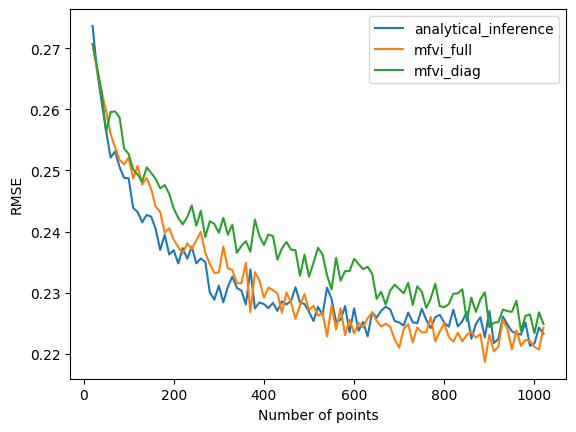

In [ ]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
for key in results_local_vi:
  plt.plot(steps, results_local_vi[key], label=key)
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_acq_plot.svg")

# Neural Processes

In [3]:
# class NPModel(nn.Module):
#     def __init__(self, num_classes, moG=1):
#         super().__init__()
#         self.mog = moG

#         self.cnn = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(64, 64, kernel_size=1),
#             nn.ReLU()
#         )

#         self.attn = nn.MultiheadAttention(
#             embed_dim=64,
#             num_heads=1,
#             dropout=0.1,
#             batch_first=True
#         )

#         self.norm = nn.LayerNorm(64)

#         self.mean_head = nn.Sequential(
#             nn.Linear(7 * 7 * 64, num_classes * moG),
#         )

#         self.logvar_head = nn.Sequential(
#             nn.Linear(7 * 7 * 64, num_classes * moG),
#         )

#         self.num_classes = num_classes

#     def forward(self, x):
#         if x.dim() == 4 and x.shape[-1] == 1:
#             x = x.permute(0, 3, 1, 2)

#         x = self.cnn(x)
#         x = x.flatten(2).transpose(1, 2)

#         attn_out, _ = self.attn(x, x, x)
#         x = self.norm(x + attn_out)

#         mean = self.mean_head(x.flatten(1)).reshape((-1, self.num_classes, self.mog))
#         logvar = self.logvar_head(x.flatten(1)).reshape((-1, self.num_classes, self.mog))
#         res = torch.stack([mean, logvar], dim=-1)

#         return res

class NPModel(nn.Module):
    def __init__(self, in_channels=1, outputs=10, mog=3):
        super().__init__()
        self.outputs = outputs
        self.mog = mog

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4),
            nn.ReLU(),
            nn.LayerNorm((25, 25)),
            nn.Conv2d(32, 32, kernel_size=4),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(1936, 256),
            nn.ReLU()
        )

        self.out = nn.Linear(256, outputs * mog * 2)

    def forward(self, x):
        if x.dim() == 4 and x.shape[-1] == 1:
            x = x.permute(0, 3, 1, 2)
        batch_size = x.size(0)

        x = self.encoder(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)

        x = self.out(x)
        x = x.view(batch_size, self.outputs, self.mog, 2)

        return x

In [4]:
class NPInferenceModel(nn.Module):
  def __init__(self, np_model: NPModel):
    super().__init__()
    self.np_model = np_model

  def forward(self, z, **kwargs):
    mogs = self.np_model(z)
    eps = torch.normal(torch.zeros((z.shape[0], mogs.shape[1], mogs.shape[2])), torch.ones((z.shape[0], mogs.shape[1], mogs.shape[2]))).to(device=device)
    means = mogs[:, :, :, 0]
    log_vars = mogs[:, :, :, 1]
    # return torch.sum(means + torch.sqrt(torch.exp(log_vars)) * eps, dim=-1)
    return torch.mean(means, dim=-1)

In [5]:
def np_acquisition_fn(T, model, x):
  model.eval()
  mog = model(x.to(device=device))
  return torch.sum(torch.sum(torch.exp(mog[:, :, :, 1]), dim=-1), dim=-1).detach()

In [6]:
def call_batchwise_np_acq(model, x, batch_size=164):
  return torch.concat([np_acquisition_fn(1, model, x[i:i+batch_size]) for i in range(0, x.shape[0], batch_size)], dim=0)

In [7]:
def evaluate_np(model, x, y, batch_size=164):
  y_hat = torch.concat([model(x[i:i+batch_size]) for i in range(0, x.shape[0], batch_size)], dim=0)
  return rmse_loss(y, y_hat).detach()

In [8]:
def find_best_decay_np(x_train, y_train, x_val, y_val):
    weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
    best_score = 0
    best_model_state = None
    best_i = 0
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    for i, dec in enumerate(weight_decays):

        model = NPModel().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=dec)
        total_loss = 0
        non_increasing = 0
        best_loss = None

        for epoch in range(150):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = nll_logvar(yb.to(dtype=logits.dtype), logits, model.mog)
                total_loss += loss.item()
                print(loss.item())

                loss.backward()
                optimizer.step()
            if best_loss is None or total_loss < best_loss:
                non_increasing = 0
                best_loss = total_loss
            else:
                if non_increasing == 4:
                    break
                non_increasing += 1
            total_loss = 0

        inf_model = NPInferenceModel(model)
        val_acc = accuracy_classification(x_val, y_val, inf_model, device=device, batch_size=batch_size)
        val_acc = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, inf_model.to(device=device))
        

        if val_acc > best_score or i == 0:
            best_score = val_acc
            best_i = i
            best_model_state = model.state_dict()

        del model # save space if running locally
        gc.collect()
        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()

    best_model = NPModel().to(device)
    best_model.load_state_dict(best_model_state)
    test_acc = evaluate(x_test.to(device=device), y_test.to(device=device), rmse_loss, NPInferenceModel(best_model).to(device=device))
    return best_model, test_acc

In [9]:
import os
def train_once_local_opt_np(x_train_cur, y_train_cur, Xs, i):
  if os.path.exists(f"./model_artifacts/np_model_new_{i}.pt"):
    model_curr = NPModel()
    model_curr.load_state_dict(torch.load(f"./model_artifacts/np_model_new_{i}.pt", weights_only=True))
    model_curr.to(device=device)
    test_score = evaluate_np(NPInferenceModel(model_curr).to(device=device), x_test.to(device), y_test.to(device))
  else:
    model_curr, test_score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
    torch.save(model_curr.state_dict(), f"./model_artifacts/np_model_new_{i}.pt")
  acq_scores = call_batchwise_np_acq(model_curr, Xs, batch_size=512)
  x_new = acq_scores.topk(acquired_points).indices
  return test_score, x_new

In [10]:
from tqdm import tqdm
def train_full_local_np(Xs, ys, x_init_train, y_init_train):
  scores = []
  x_train_cur = x_init_train.detach().clone()
  y_train_cur = y_init_train.detach().clone()
  for i in tqdm(range(acquisition_times)):
    score, x_new = train_once_local_opt_np(x_train_cur, y_train_cur, Xs, i)
    x_new_t = torch.tensor(x_new, dtype=torch.long)
    x_train_cur = torch.cat([x_train_cur, Xs[x_new_t.cpu()].to(device)], dim=0)
    y_train_cur = torch.cat([y_train_cur, ys[x_new_t.cpu()].to(device)], dim=0)
    mask = torch.ones(Xs.shape[0], dtype=torch.bool)
    mask[x_new_t.cpu()] = False
    Xs = Xs[mask]
    ys = ys[mask]
    scores.append(score)

  model, score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
  scores.append(score)
  return torch.Tensor(scores), model

In [11]:
def train_acquisition_np():
  os.makedirs("./model_artifacts", exist_ok=True)
  os.makedirs("./vi_results", exist_ok=True)
  scores = []
  for i in range(3):
    # if os.path.exists(f"./vi_results/{i}np_local.npy"):
    #   score = np.load(f"./vi_results/{i}np_local.npy")
    #   score = torch.Tensor(score)
    # else:
    score, model = train_full_local_np(X_p, y_p, x_train_new, y_train_new)
    np.save(f"./vi_results/{i}np_local.npy", score.detach().cpu().numpy())
    print(score)
    scores.append(score)    
  meaned_scores = torch.mean(torch.stack(scores), dim=0)

  return meaned_scores

In [12]:
res = train_acquisition_np()
print(res)
np.save(f"./vi_results/np_results.npy", res.numpy())

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/9_/b7fsj07x3p78x_60wdfj2z_h0000gn/T/ipykernel_8282/783859095.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_new_t = torch.tensor(x_new, dtype=torch.long)
  1%|          | 1/100 [00:03<06:15,  3.79s/it]

-314.3002014160156
-345.1119384765625
-393.66827392578125
-477.14483642578125
-494.81103515625
-429.532958984375
-446.1357116699219
-434.40423583984375
-464.341064453125
-472.05169677734375
-314.30975341796875
-351.62396240234375
-410.34649658203125
-492.1752014160156
-428.3518371582031
-450.40478515625
-426.90728759765625
-449.66607666015625
-461.26654052734375
-313.88934326171875
-347.7948303222656
-397.61163330078125
-477.98956298828125
-494.54302978515625
-494.390869140625
-451.36968994140625
-427.18280029296875
-458.843017578125
-458.6349182128906
-314.759521484375
-353.7203369140625
-411.38153076171875
-491.725830078125
-499.4891357421875
-433.0091552734375
-460.66094970703125
-480.54522705078125
-466.9940490722656
-495.1375427246094
-315.448486328125
-355.49713134765625
-411.6719970703125
-491.8846740722656
-396.6808166503906
-412.9322509765625
-436.9129638671875
-443.92169189453125
-460.6304931640625


  1%|          | 1/100 [00:09<16:08,  9.79s/it]


KeyboardInterrupt: 

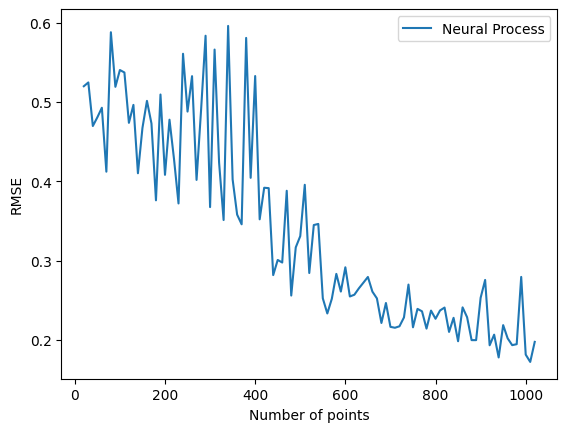

In [ ]:
res = np.load('./vi_results/np_results.npy')
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, res, label="Neural Process")
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_results/np_acq_plot.svg")

# Compare individual to constant variance

In [28]:
class HierarchicalRegressorEnergy(nn.Module):
    def __init__(self, input_dim=11, hidden_dim=128, output_dim=2):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.last = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.conv(x)
        return self.last(x)

In [29]:
x_train_new, y_train_new, X_p, y_p, x_val, y_val, x_test, y_test = load_uci(val_size=1000)
device = torch.device("mps") if torch.mps.is_available() else "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else device
x_train_new = x_train_new.to(dtype=torch.float32).to(device)
y_train_new = y_train_new.to(dtype=torch.float32).to(device)
X_p = X_p.to(dtype=torch.float32)
y_p = y_p.to(dtype=torch.float32)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)
batch_size = 128
epochs = 70
acquired_points = 10
num_classes = 2
acquisition_times = 100
data_variances = [0.1, 0.25, 0.5, 6, 8, 10, 16, 20]

In [30]:
def compute_individual():
  scores = []
  for i in range(3):
    score, model = train_full_local_pv("analytical_inference", X_p, y_p, x_train_new, y_train_new, None, True, HierarchicalRegressorEnergy)
    np.save(f"./vi_results/{i}ai_individual.npy", score.detach().cpu().numpy())
    print(score.detach())
    scores.append(score)
  meaned_scores = torch.mean(torch.stack(scores), dim=0)
  return meaned_scores

def compute_constant():
  scores = []
  for i in range(3):
    score, model = train_full_local_pv("analytical_inference", X_p, y_p, x_train_new, y_train_new, None, False, HierarchicalRegressorEnergy)
    np.save(f"./vi_results/{i}ai_constant.npy", score.detach().cpu().numpy())
    print(score.detach())
    scores.append(score)
  meaned_scores = torch.mean(torch.stack(scores), dim=0)
  return meaned_scores

100%|██████████| 100/100 [04:06<00:00,  2.46s/it]


tensor([778.2766, 782.5250, 781.5397, 779.9775, 779.5610, 779.1581, 777.5370,
        774.8864, 772.4424, 770.6949, 771.7219, 770.5123, 770.7001, 768.6781,
        763.3218, 760.5595, 766.1626, 761.4652, 769.6670, 759.4933, 759.9423,
        748.2957, 758.3538, 750.7352, 751.1382, 751.6476, 750.5267, 753.1113,
        748.3979, 743.1922, 746.3957, 749.4052, 734.1121, 741.9922, 734.0316,
        743.8204, 734.4337, 730.3789, 721.9022, 704.4176, 725.1721, 713.6151,
        724.9751, 730.3893, 720.2720, 713.5328, 717.2841, 725.2526, 732.7756,
        710.5327, 693.0352, 702.5291, 697.2748, 703.9219, 710.2036, 714.5450,
        670.3862, 653.9392, 674.0518, 698.0504, 692.1909, 687.6348, 690.1193,
        677.9458, 706.3511, 673.4547, 626.9675, 655.3734, 675.9492, 671.9615,
        653.8740, 610.4380, 689.3116, 635.0799, 679.9645, 580.1929, 688.6171,
        619.9385, 659.3879, 632.7986, 621.0421, 659.5291, 631.6832, 608.9586,
        593.5294, 636.1848, 636.3265, 625.0405, 619.5153, 557.91

100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


tensor([778.7999, 782.2462, 781.7507, 779.2882, 778.8914, 776.7336, 776.7359,
        774.7983, 778.4032, 772.8607, 770.7372, 771.0333, 767.4360, 768.4796,
        763.8007, 762.4341, 760.6513, 770.2162, 762.8398, 763.3987, 756.8118,
        759.0751, 761.6527, 755.7778, 759.6038, 760.1633, 736.4139, 750.3337,
        756.6235, 753.4125, 747.0748, 740.9725, 747.9041, 747.0881, 748.1725,
        740.4891, 741.8545, 753.9436, 728.1882, 709.9230, 720.1198, 720.1683,
        739.3872, 731.7564, 720.8810, 723.5845, 706.6756, 711.2046, 724.9939,
        734.4091, 704.8043, 673.9645, 692.4741, 711.1727, 704.2978, 711.0823,
        650.9616, 692.5308, 682.3406, 713.7384, 710.6252, 693.1755, 671.5114,
        662.3597, 701.8165, 701.2101, 637.0659, 688.2584, 620.7263, 680.2565,
        677.9340, 679.1670, 669.1097, 646.8115, 650.6295, 659.1828, 639.1018,
        618.2971, 623.4056, 631.7012, 629.0335, 596.5289, 639.3293, 618.7968,
        619.7640, 619.6654, 560.8660, 618.8304, 575.8553, 601.44

100%|██████████| 100/100 [03:40<00:00,  2.21s/it]


tensor([778.3938, 782.3500, 781.1049, 780.5221, 778.4378, 779.4405, 776.1444,
        774.0028, 774.4879, 772.3627, 772.1624, 769.1327, 771.4150, 769.9178,
        762.6981, 769.6318, 766.5863, 763.6647, 755.8162, 761.3155, 756.7678,
        753.3198, 757.5543, 753.8909, 749.8098, 752.6183, 743.6523, 746.2726,
        749.6195, 748.9655, 741.4507, 748.6997, 736.4757, 742.4281, 727.9238,
        730.0347, 735.6978, 737.1160, 735.9402, 725.1711, 725.9172, 723.9205,
        737.3083, 730.0632, 723.9069, 724.8273, 734.9945, 719.2112, 723.0771,
        724.0319, 714.3853, 702.3600, 714.8824, 696.9285, 708.4710, 709.7618,
        680.8873, 672.0372, 696.3507, 709.2191, 721.4867, 646.0721, 706.4015,
        669.6824, 648.0027, 671.6965, 679.1086, 685.1238, 622.1403, 657.0007,
        662.7305, 687.0660, 646.2661, 659.8997, 667.5131, 667.0121, 675.8907,
        589.1203, 654.1549, 630.3969, 637.9036, 586.6738, 645.0048, 650.3475,
        617.6260, 618.6707, 564.8254, 560.2947, 640.3597, 586.95

100%|██████████| 100/100 [04:52<00:00,  2.93s/it]


tensor([776.5618, 782.1720, 781.2281, 771.8420, 780.2813, 777.1577, 774.9839,
        776.0990, 746.1066, 772.4431, 771.8818, 770.5615, 769.3801, 771.3406,
        770.7681, 763.8856, 764.2468, 762.0801, 761.9078, 760.1300, 763.8555,
        760.9103, 752.3928, 759.0739, 744.3051, 752.5022, 749.0822, 742.3914,
        743.1265, 750.0063, 749.8011, 738.2117, 752.1974, 741.7784, 739.3576,
        724.9708, 728.2055, 741.9601, 741.0533, 723.6422, 721.0186, 699.8231,
        727.3875, 729.4789, 715.4539, 720.3249, 718.0688, 708.1782, 741.2626,
        722.6116, 713.1146, 707.9382, 666.2338, 724.7947, 705.3470, 688.6223,
        683.0103, 717.5782, 676.5744, 692.8765, 676.3866, 703.0402, 691.4576,
        678.2250, 686.6502, 690.9138, 668.5298, 670.1208, 685.7730, 681.4636,
        661.1904, 679.0995, 629.5607, 688.7240, 642.6021, 662.9845, 577.0067,
        672.9385, 567.7961, 655.7070, 584.4067, 654.6406, 645.4766, 608.9684,
        626.9501, 587.2394, 540.3741, 645.1894, 613.9376, 539.88

100%|██████████| 100/100 [04:47<00:00,  2.87s/it]


tensor([778.0847, 782.2855, 780.9107, 781.2100, 780.0011, 778.9470, 775.3947,
        752.5275, 772.7422, 770.7690, 772.8026, 771.4650, 767.3446, 764.3210,
        765.8013, 763.4830, 769.2148, 756.0669, 755.6539, 754.6005, 762.0219,
        763.0831, 761.3826, 753.6214, 751.2980, 752.8865, 748.3737, 752.8532,
        742.0128, 733.2894, 748.0048, 744.5540, 749.4258, 749.8881, 737.2788,
        744.3534, 742.7372, 736.7258, 731.0422, 738.6275, 741.4611, 732.7877,
        728.0594, 726.3582, 726.3956, 722.7042, 711.0267, 722.5953, 728.7080,
        719.8274, 703.2563, 713.4418, 699.8182, 717.4738, 707.4401, 723.7682,
        678.2985, 694.4189, 698.3460, 670.7458, 682.9320, 699.7095, 691.9512,
        675.8187, 686.7115, 665.7035, 644.6874, 666.4908, 693.4537, 640.6718,
        685.5952, 673.2311, 682.5112, 701.3134, 649.6443, 629.8770, 645.1140,
        657.0787, 643.7009, 659.3403, 604.2175, 624.8745, 646.3520, 623.5148,
        577.8910, 642.4133, 609.5305, 669.1144, 574.4607, 615.55

100%|██████████| 100/100 [05:10<00:00,  3.10s/it]


tensor([778.4275, 782.6545, 780.3745, 780.5429, 779.1224, 776.7773, 775.8634,
        774.5106, 773.7772, 772.0505, 771.6709, 772.7352, 770.2573, 767.5151,
        764.2850, 757.7539, 763.4645, 766.2758, 764.4449, 759.4810, 759.4893,
        764.2246, 755.0964, 750.1484, 751.9464, 754.3891, 749.6511, 747.9267,
        743.7366, 754.3344, 746.1399, 744.9275, 738.8660, 741.1548, 738.6595,
        730.4306, 739.9362, 732.8960, 727.8822, 723.0831, 719.4909, 726.5568,
        732.6861, 709.5421, 723.4445, 725.2802, 715.0450, 704.4444, 716.3010,
        716.8616, 703.4081, 704.0643, 702.7256, 717.7352, 658.7565, 704.2091,
        687.4509, 691.1768, 661.5500, 704.6725, 683.5189, 690.3047, 710.4576,
        674.8537, 688.9248, 675.2132, 676.1195, 671.0312, 669.0282, 683.7789,
        662.2880, 685.6980, 679.1523, 666.7188, 664.3207, 643.2922, 657.5468,
        633.8046, 644.9461, 587.1834, 661.3768, 644.8381, 582.1113, 649.3846,
        653.4540, 621.8903, 634.9659, 650.7924, 617.6933, 637.80

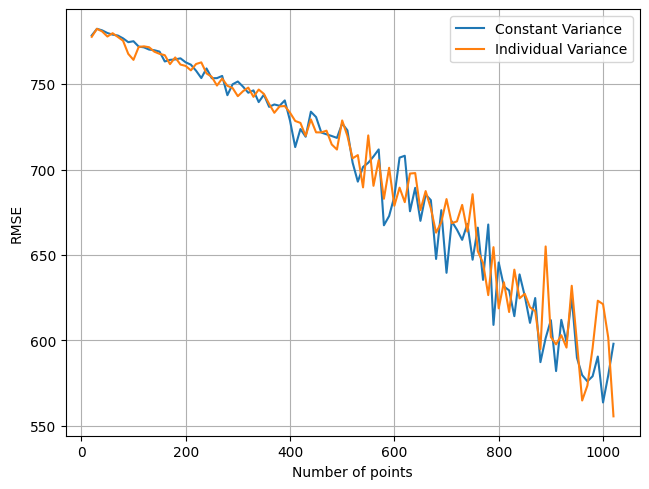

In [32]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, compute_constant(), label="Constant Variance")
plt.plot(steps, compute_individual(), label="Individual Variance")
plt.tight_layout()
plt.grid()
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_individual_acq_plot.svg")

# RMSE compare plots

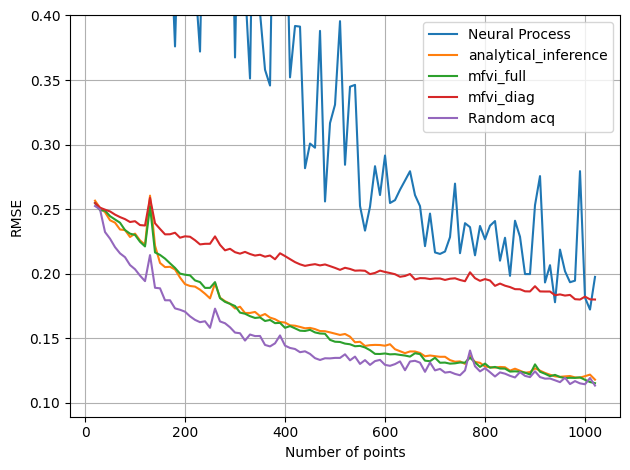

In [ ]:
res_np = np.load('./vi_results/np_results.npy')
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, res_np, label="Neural Process")
for key in vi_acq_functions:
  res = np.load(f"./{str(key)}_local.npy")
  plt.plot(steps, res, label=key)
res_rand = np.load("./results/random_rmse.npy")
plt.plot(steps, res_rand, label="Random acq")
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.ylim(top=0.4)
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig("./vi_results/all_rmse_plots.svg")